# Dictionary Learning based Beamformer

Parameters to investigate:
* Number of interferences in training vs testing
* Interferences angles in training vs testing
* Interference power in training vs testing
* Number of snapshots and training samples in training
* Input SNR
* Number of microphones

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_palette
flatui = ["#3498db", "#9b59b6", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
set_palette(flatui)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linewidth'] = 0.25
plt.rcParams['grid.alpha'] = 0.2
plt.style.use('seaborn-talk')

from tqdm import tnrange, tqdm_notebook
from dlbeamformer_utilities import compute_steering_vector_ULA, compute_MVDR_weight, check_distortless_constraint, uniform_linear_array, generate_gaussian_samples, generate_gaussian_training_data
from dlbeamformer import MicrophoneArray, BaseDLBeamformer
from config import sound_speed
random_seed = 0

In [2]:
# Microphone array
d = 0.5
n_mics = 10
array_geometry = uniform_linear_array(n_mics=n_mics, spacing=d)
microphone_array = MicrophoneArray(array_geometry)

# Parameters
from scipy import signal
sampling_frequency = 16000
n_samples_per_frame = 512 # frame length
hop_size = n_samples_per_frame // 2 # num_samples_per_shift
n_samples_per_overlap = n_samples_per_frame - hop_size
n_fft_bins = (int)(n_samples_per_frame / 2)
n_fft_bins_per_block = 8
n_fft_blocks = int(n_fft_bins / n_fft_bins_per_block)

azimuth_resolution_degree = 5
n_azimuth_grids = int(360 / azimuth_resolution_degree)

In [3]:
# Compute delays
tau = np.zeros((n_azimuth_grids, n_mics), dtype=np.float32)
for i_mic in range(n_mics):
    for i_azimuth in range(n_azimuth_grids):
        theta = 2*np.pi*i_azimuth/n_azimuth_grids
        tau[i_azimuth, i_mic] = i_mic * d * np.cos(theta) * sampling_frequency / sound_speed

# Compute steering vectors for each frequency bin
steering_vectors = np.zeros((n_fft_bins, n_azimuth_grids, n_mics), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    proxy = 2*np.pi*(i_fft_bin/n_samples_per_frame) * tau
#     steering_vectors[i_fft_bin] = np.exp( -1j*2*np.pi*(i_fft_bin/n_samples_per_frame) * tau )
    steering_vectors[i_fft_bin] = np.cos(proxy) - 1j * np.sin(proxy)

In [ ]:
# Source angle and steering vectors
source_angle = 0;
i_source_angle = int(np.floor(source_angle / azimuth_resolution_degree))

In [4]:
# Split train/test data
import os
from os import listdir
from os.path import join
datapath = "CMU_ARCTIC/cmu_us_bdl_arctic/wav"
train_data_folder = join(datapath, 'train')
test_data_folder = join(datapath, 'test')
if not os.path.exists(train_data_folder):
    os.mkdir(train_data_folder)
if not os.path.exists(test_data_folder):
    os.mkdir(test_data_folder)    
filenames = [f for f in listdir(datapath) if os.path.isfile( os.path.join(datapath, f) )]

from sklearn.model_selection import train_test_split
train_data_filenames, test_data_filenames = train_test_split(filenames, test_size=0.2)

import shutil
for i_train_data_filename in range(len(train_data_filenames)):
    train_data_filename = train_data_filenames[i_train_data_filename]
    shutil.move(join(datapath, train_data_filename), join(train_data_folder, train_data_filename))

for i_test_data_filename in range(len(test_data_filenames)):
    test_data_filename = test_data_filenames[i_test_data_filename]
    shutil.move(join(datapath, test_data_filename), join(test_data_folder, test_data_filename))

In [5]:
from scipy.io import wavfile
from IPython.display import Audio
train_data = []
test_data = []
train_data_filenames = [f for f in listdir(train_data_folder) if os.path.isfile( join(train_data_folder, f))]
for i_train_data_filename in range(len(train_data_filenames)):
    f_path = join(train_data_folder, train_data_filenames[i_train_data_filename])
    if f_path.endswith('.wav'):
        sampling_frequency, train_data_example = wavfile.read(f_path)
    train_data.append(train_data_example)
    
for i_test_data_filename in range(len(test_data_filenames)):
    f_path = join(test_data_folder, test_data_filenames[i_test_data_filename])
    if f_path.endswith('.wav'):
        sampling_frequency, test_data_example = wavfile.read(f_path)
    test_data.append(test_data_example)

In [6]:
# Load some test data
from scipy.io import wavfile
from IPython.display import Audio
test_data_filenames = [f for f in listdir(test_data_folder) if os.path.isfile( os.path.join(test_data_folder, f) )]
sampling_frequency, source_signal = wavfile.read(join(test_data_folder, test_data_filenames[0]))
# phi_s = np.mean(ss.dot(source_signal))
Audio(source_signal, rate=sampling_frequency)

sampling_frequency, interference_signal = wavfile.read(join(test_data_folder, test_data_filenames[9]))

Audio(interference_signal, rate=sampling_frequency)
if len(source_signal) < len(interference_signal):
    interference_signal = interference_signal[:len(source_signal)]
else:
    source_signal = source_signal[:len(interference_signal)]
n_samples = len(source_signal)
Audio(interference_signal, rate=sampling_frequency, autoplay=True)

In [7]:
# Compute STFT for source and interference signals
n_frames = int(np.floor(n_samples / hop_size))
stft_window_name = "hann"
stft_window = signal.get_window(stft_window_name, Nx=n_samples_per_frame)
source_stft = np.zeros((n_fft_bins, n_frames, n_mics), dtype=np.complex64)
interference_stft = np.zeros((n_fft_bins, n_frames, n_mics), dtype=np.complex64)
for i_mic in range(n_mics):
    frequency_bins, time_bins, i_mic_source_stft = signal.stft(
        source_signal, fs=sampling_frequency, window=stft_window, 
        nperseg=n_samples_per_frame, noverlap=n_samples_per_overlap, 
        nfft=n_samples_per_frame, padded=True)
    source_stft[:, :, i_mic] = i_mic_source_stft[:-1,1:-1]
    _, _, i_mic_interference_stft = signal.stft(
        interference_signal, fs=sampling_frequency, window=stft_window, 
        nperseg=n_samples_per_frame, noverlap=n_samples_per_overlap, 
        nfft=n_samples_per_frame, padded=True)
    interference_stft[:, :, i_mic] = i_mic_interference_stft[:-1,1:-1]
# i_mic_stft_db = 20*np.log10( np.abs(source_stft[:, :, 1]) / np.max(np.abs(source_stft[:, :, 1])))
# fig = plt.figure(figsize=(9, 10));
# ax = fig.add_subplot(211)
# img = ax.imshow(i_mic_stft_db, origin="lower", aspect="auto", extent=[0, time_bins[-1], 0, freq_bins[-1]/1000], cmap="RdBu_r")
# fig.colorbar(img, ax=ax, orientation="horizontal")
# ax.set_xlabel("Time [s]"); ax.set_ylabel("Frequency [KHz]"); 
# ax.set_title("Spectrogram");
# ax = fig.add_subplot(212)
# ax.plot(np.arange(n_samples)/fs, source_signal);
# ax.set_xlabel("Time [s]"); ax.set_ylabel("Amplitude"); ax.set_xlim(left=0);
# ax.set_title("Raw waveform in time")
# plt.tight_layout()

In [8]:
interference_angle = 45
i_interference_angle = int(np.floor(interference_angle / azimuth_resolution_degree))
source_stft_multichannel = np.zeros((n_fft_bins, n_frames, n_mics), dtype=np.complex64)
interference_stft_multichannel = np.zeros((n_fft_bins, n_frames, n_mics), dtype=np.complex64)

source_steering_vectors = steering_vectors[:, i_source_angle, :].reshape(
    steering_vectors.shape[0], 1, steering_vectors.shape[2]
)
interference_steering_vectors = steering_vectors[:, i_interference_angle, :].reshape(
    steering_vectors.shape[0], 1, steering_vectors.shape[2]
)
source_stft_multichannel = source_steering_vectors * source_stft
interference_stft_multichannel = interference_steering_vectors * interference_stft
# interference_stft_multichannel += generate_gaussian_samples(noise_sigma, interference_stft_multichannel.shape)
# for i_fft_bin in range(n_fft_bins):
#     i_fft_bin_source_steering_vector = steering_vectors[i_fft_bin, i_source_angle, :]
#     source_stft_multichannel[i_fft_bin, :, :] = source_stft[i_fft_bin, :, :]*i_fft_bin_source_steering_vector
# #     i_fft_bin_interference_steering_vector = steering_vectors[i_fft_bin, i_interference_angle, :]
# #     interference_stft_multichannel[i_fft_bin, :, :] = interference_stft[i_fft_bin, :, :]*i_fft_bin_interference_steering_vector
#     print(i_fft_bin)
    
received_stft_multichannel = source_stft_multichannel + interference_stft_multichannel

noise_sigma = 1;
np.random.seed(random_seed)
for i_mic in range(n_mics):
    interference_stft_multichannel[:, :, i_mic] += generate_gaussian_samples(noise_sigma, (n_fft_bins, n_frames))
    received_stft_multichannel[:, :, i_mic] += generate_gaussian_samples(noise_sigma, (n_fft_bins, n_frames))

In [9]:
# i_mic_stft_db = 20*np.log10( np.abs(received_stft_multichannel[:, :, 1]) / np.max(np.abs(source_stft[:, :, 1])))
# fig = plt.figure(figsize=(9, 10));
# ax = fig.add_subplot(211)
# img = ax.imshow(i_mic_stft_db, origin="lower", aspect="auto", extent=[0, time_bins[-1], 0, frequency_bins[-1]/1000], cmap="RdBu_r")
# fig.colorbar(img, ax=ax, orientation="horizontal")
# ax.set_xlabel("Time [s]"); ax.set_ylabel("Frequency [KHz]"); 
# ax.set_title("Spectrogram");
# ax = fig.add_subplot(212)
# ax.plot(np.arange(n_samples)/sampling_frequency, source_signal);
# ax.set_xlabel("Time [s]"); ax.set_ylabel("Amplitude"); ax.set_xlim(left=0);
# ax.set_title("Raw waveform in time")
# plt.tight_layout()

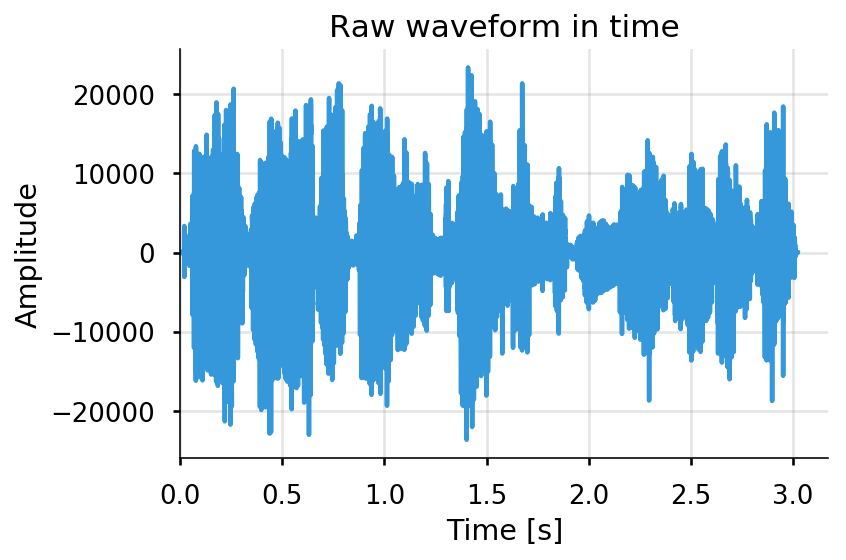

In [10]:
# Listen to the received signals at the microphones which are mixtures of the source and 
# interference signals
i_mic = 0
time_samples, received_signal_i_mic = signal.istft(received_stft_multichannel[:, :, i_mic], fs=sampling_frequency, 
                     window=stft_window, nperseg=n_samples_per_frame,
                     noverlap=n_samples_per_overlap, nfft=n_samples_per_frame)
fig = plt.figure(); ax = fig.add_subplot(111)
ax.plot(time_samples, received_signal_i_mic);
ax.set_xlabel("Time [s]"); ax.set_ylabel("Amplitude"); ax.set_xlim(left=0);
ax.set_title("Raw waveform in time")
plt.tight_layout()
Audio(received_signal_i_mic, rate=sampling_frequency, autoplay=True)

In [11]:
# Compute spatial sample covariance matrices
Rii = np.zeros((n_fft_bins, n_mics, n_mics), dtype=np.complex64)
Rxx = np.zeros((n_fft_bins, n_mics, n_mics), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    ii = interference_stft_multichannel[i_fft_bin, :, :]
    Rii[i_fft_bin, :, :] = ii.transpose().conjugate().dot(ii)
    xx = received_stft_multichannel[i_fft_bin, :, :]
    Rxx[i_fft_bin, :, :] = xx.transpose().conjugate().dot(ii)

In [12]:
# Compute MVDR weights
mvdr_weights = np.zeros((n_fft_bins, n_mics), dtype=np.complex64)
mpdr_weights = np.zeros((n_fft_bins, n_mics), dtype=np.complex64)
if source_steering_vectors.shape[1] == 1:
    source_steering_vectors = np.squeeze(source_steering_vectors, axis=1)
for i_fft_bin in range(n_fft_bins):
    sample_covariance_matrix = Rii[i_fft_bin, :, :]
    inverse_sample_covariance_matrix = np.linalg.inv(sample_covariance_matrix)
    normalization_factor = source_steering_vectors[i_fft_bin, :].transpose().conjugate().dot(
        inverse_sample_covariance_matrix
    ).dot(source_steering_vectors[i_fft_bin, :])
    mvdr_weights[i_fft_bin, :] = inverse_sample_covariance_matrix.dot(source_steering_vectors[i_fft_bin, :]) / normalization_factor
    
    sample_covariance_matrix = Rxx[i_fft_bin, :, :]
    inverse_sample_covariance_matrix = np.linalg.inv(sample_covariance_matrix)
    normalization_factor = source_steering_vectors[i_fft_bin, :].transpose().conjugate().dot(
        inverse_sample_covariance_matrix
    ).dot(source_steering_vectors[i_fft_bin, :])
    mpdr_weights[i_fft_bin, :] = inverse_sample_covariance_matrix.dot(source_steering_vectors[i_fft_bin, :]) / normalization_factor    

In [13]:
source_steering_vectors[i_fft_bin, :].transpose().conjugate().shape

(10,)

In [14]:
# Apply beamformer weights
print(mvdr_weights.shape, received_stft_multichannel.shape)
mvdr_stft_out = np.zeros((n_fft_bins, n_frames), dtype=np.complex64)
mpdr_stft_out = np.zeros((n_fft_bins, n_frames), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    mvdr_stft_out[i_fft_bin, :] = mvdr_weights[i_fft_bin, :].transpose().conjugate().dot(
        received_stft_multichannel[i_fft_bin, :, :].transpose())
    mpdr_stft_out[i_fft_bin, :] = mpdr_weights[i_fft_bin, :].transpose().conjugate().dot(
        received_stft_multichannel[i_fft_bin, :, :].transpose())
### Alternative implementation for stft_out    
# a = ( mvdr_weights.reshape((256, 1, 10)).conjugate()*received_stft_multichannel ).sum(axis=2)
#############################################
time_samples, mvdr_out = signal.istft(mvdr_stft_out, fs=sampling_frequency, 
                     window=stft_window, nperseg=n_samples_per_frame,
                     noverlap=n_samples_per_overlap, nfft=n_samples_per_frame)
time_samples, mpdr_out = signal.istft(mpdr_stft_out, fs=sampling_frequency, 
                     window=stft_window, nperseg=n_samples_per_frame,
                     noverlap=n_samples_per_overlap, nfft=n_samples_per_frame)
Audio(mvdr_out, rate=sampling_frequency, autoplay=True)
# Audio(mpdr_out, rate=sampling_frequency, autoplay=True)


(256, 10) (256, 190, 10)


In [18]:
# Train dictionary
steering_vectors.shape
noise_sigma = 1;
np.random.seed(random_seed)
n_train_examples_each_azimuth = len(train_data[0:1])
dictionary = np.zeros((n_fft_bins, n_mics, n_train_examples_each_azimuth*n_azimuth_grids), dtype=np.complex64)
i_dictionary_atom = 0
for i_train_azimuth in range(n_azimuth_grids):
    for i_train_example in range(n_train_examples_each_azimuth):
        interference_train_signal = train_data[i_train_example]
        n_interference_train_frames = int(np.floor(len(interference_train_signal) / hop_size))
        interference_train_stft = np.zeros((n_fft_bins, n_interference_train_frames, n_mics), dtype=np.complex64)
        for i_mic in range(n_mics):
            frequency_bins, time_bins, i_mic_interference_train_stft = signal.stft(
                interference_train_signal, fs=sampling_frequency, window=stft_window, 
                nperseg=n_samples_per_frame, noverlap=n_samples_per_overlap, 
                nfft=n_samples_per_frame, padded=True)
            interference_train_stft[:, :, i_mic] = i_mic_interference_train_stft[:-1,1:-1]
        interference_train_stft_multichannel = interference_steering_vectors * interference_train_stft
        
        for i_mic in range(n_mics):
            interference_train_stft_multichannel[:, :, i_mic] += generate_gaussian_samples(noise_sigma, (n_fft_bins, n_interference_train_frames))
            
        for i_fft_bin in range(n_fft_bins):
            ii = interference_train_stft_multichannel[i_fft_bin, :, :]
            sample_covariance_matrix = ii.transpose().conjugate().dot(ii)
            inverse_sample_covariance_matrix = np.linalg.inv(sample_covariance_matrix)
            normalization_factor = source_steering_vectors[i_fft_bin, :].transpose().conjugate().dot(
                inverse_sample_covariance_matrix).dot(source_steering_vectors[i_fft_bin, :])
            dictionary[i_fft_bin, :, i_dictionary_atom] = inverse_sample_covariance_matrix.dot(source_steering_vectors[i_fft_bin, :]) / normalization_factor
        i_dictionary_atom += 1

(256, 10, 72)